In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
# import squidpy as sq

from scipy.spatial import cKDTree
# import muon as mu
import mudata as mu

In [2]:
import liana as li

In [3]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"

In [4]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
rna = mdata.mod["rna"]
msi = mdata.mod["msi"]

/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
mdata

MuData object with n_obs × n_vars = 6125 × 33823
  2 modalities
    rna:	3120 x 32285
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region'
      var:	'gene_ids', 'feature_types', 'genome'
      uns:	'spatial'
      obsm:	'spatial'
    msi:	3005 x 1538
      obs:	'leiden', 'array_row', 'array_col', 'x', 'y'
      var:	'mean', 'std'
      uns:	'leiden_colors', 'spatial'
      obsm:	'X_pca', 'spatial'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

In [6]:
rna_pos = rna.obsm['spatial'].copy()
msi_pos = msi.obsm['spatial'].copy()

In [7]:
# train kdtree on rna positions
reference = cKDTree(rna_pos)
target = cKDTree(msi_pos)


In [8]:
# find nearest neighbor for each msi spot
distances, indices = reference.query(msi_pos, k=1)

In [9]:
# calculate proximities
proximity = 1 - (distances / np.max(distances))
# get barcode of nearest neighbor
msi.obs['knn_barcode'] = rna.obs.iloc[indices, :].index
# get proximity of nearest neighbor
msi.obs['knn_proximity'] = proximity

(array([   5.,   21.,   21.,   13.,   40.,   39.,   34.,   37.,   69.,
        2726.]),
 array([0.        , 0.09943432, 0.19886864, 0.29830296, 0.39773728,
        0.4971716 , 0.59660593, 0.69604025, 0.79547457, 0.89490889,
        0.99434321]),
 <BarContainer object of 10 artists>)

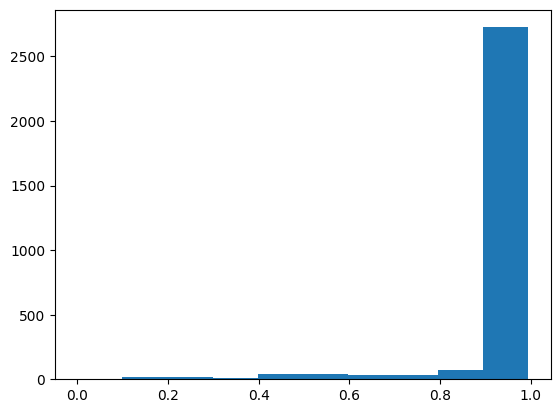

In [10]:
# histrogram of distances
from matplotlib import pyplot as plt
plt.hist(proximity, bins=10)

... storing 'knn_barcode' as categorical
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


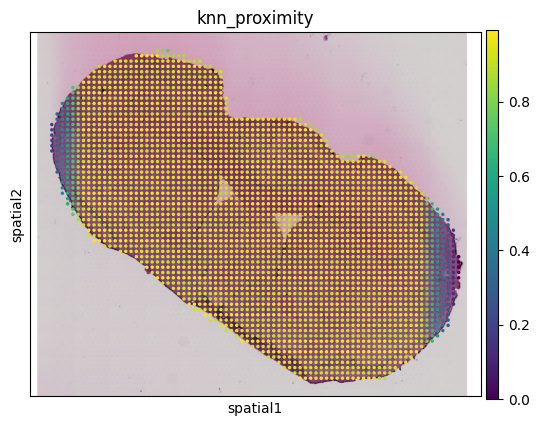

In [11]:
sc.pl.spatial(msi, color="knn_proximity")

/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


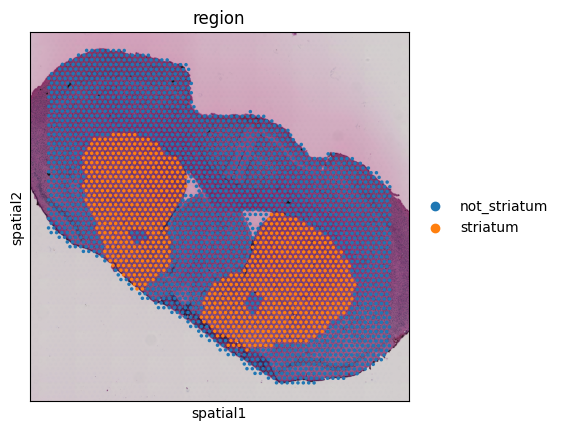

In [12]:
sc.pl.spatial(rna, color="region")

In [13]:
dist = reference.sparse_distance_matrix(target,
                                        max_distance=100 * 5,
                                        output_type="coo_matrix")


In [14]:
dist = dist.tocsr()

In [15]:
dist

<3120x3005 sparse matrix of type '<class 'numpy.float64'>'
	with 7091 stored elements in Compressed Sparse Row format>

In [16]:
(dist @ mdata.mod['msi'].X).shape

(3120, 1538)

In [17]:
dist

<3120x3005 sparse matrix of type '<class 'numpy.float64'>'
	with 7091 stored elements in Compressed Sparse Row format>

In [18]:
li.ut.spatial_neighbors(mdata.mod['rna'], cutoff=0.1, bandwidth=100)

In [19]:
mdata.mod['rna'].obsp['spatial_connectivities'] @ mdata.mod['rna'].X

<3120x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

try spatialdata

In [ ]:
import spatialdata as sd

In [ ]:
from spatialdata.models import TableModel, ShapesModel
from anndata import AnnData
import numpy as np
from spatialdata import SpatialData

# shapes
visium_locations0 = ShapesModel.parse(np.random.rand(10, 2), geometry=0, radius=1)
visium_locations1 = ShapesModel.parse(np.random.rand(10, 2), geometry=0, radius=1)
visium_locations2 = ShapesModel.parse(np.random.rand(10, 2), geometry=0, radius=1)

# shared table
adata = AnnData(np.random.rand(30, 20000))
adata.obs['region'] = (['visium0'] * 10 + ['visium1'] * 10 + ['visium2'] * 10).copy()
adata.obs['region'] = adata.obs['region'].astype('category')
adata.obs['instance_id'] = np.array(list(range(10)) + list(range(10)) + list(range(10)))
adata = TableModel.parse(adata, region=['visium0', 'visium1', 'visium2'], region_key='region', instance_key='instance_id')

sdata = SpatialData(shapes={'visium0': visium_locations0, 'visium1': visium_locations1, 'visium2': visium_locations2}, table=adata)
sdata

In [ ]:
# shapes 
rna_locations = ShapesModel.parse(rna_pos, geometry=0, radius=1)
msi_locations = ShapesModel.parse(msi_pos, geometry=0, radius=1)


In [ ]:
mdata.obs['region'] = (['rna'] * rna_pos.shape[0] + ['msi'] * msi_pos.shape[0]).copy()
mdata.obs['instance_id'] = mdata.obs.index

In [ ]:
mdata = TableModel.parse(mdata, region=['msi', 'rna'], region_key='region', instance_key='instance_id')

In [ ]:
mdata

In [ ]:
sdata = SpatialData(shapes={'msi':msi_locations, 'rna':rna_locations}, table=mdata)

In [ ]:
sdata

In [ ]:
?TableModel.parse